## CSC 215 Mini Project #1
#### Team members: Harshil Shah and Swapnil Patel

In [2]:
import numpy as np
import pandas as pd
import os
import json
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools
print("Imported")

Imported


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Preprocessing
### Business Data Processing

In [0]:
#data_path = "D:\Downloads\CSC 215"
data_path = "/content/gdrive/My Drive/CSC 215/Dataset"
business_json = "yelp_academic_dataset_business.json"
reviews_json = "yelp_academic_dataset_review.json"
reviews_tsv = "review_stars.tsv"
business_data = pd.read_json(os.path.join(data_path, business_json), lines =True)

In [4]:
business_data.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",Montréal,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
3,211 W Monroe St,None,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Phoenix,None,1,33.449999,-112.076979,Geico Insurance,,85003,8,1.5,AZ
4,2005 Alyth Place SE,{'BusinessAcceptsCreditCards': 'True'},8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Calgary,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,51.035591,-114.027366,Action Engine,,T2H 0N5,4,2.0,AB


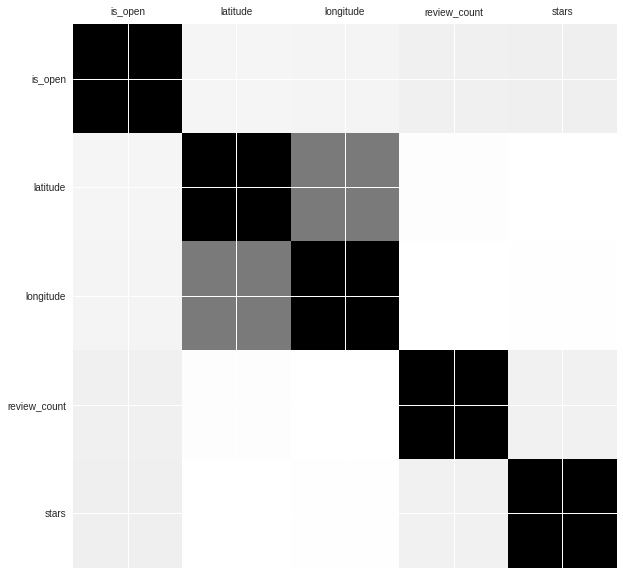

In [5]:
corr = business_data.corr()

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

plt.show()

Removing unnecessary columns

In [6]:
columns = ["address", "attributes", "categories", "city", "hours", "is_open", 
            "latitude", "longitude", "name", "neighborhood", "postal_code", "state"]

business_data_updated = business_data.drop(columns, axis = 1)
print("Columns dropped", columns)

Columns dropped ['address', 'attributes', 'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'neighborhood', 'postal_code', 'state']


In [7]:
business_data_updated.head()

,business_id,review_count,stars
0,Apn5Q_b6Nz61Tq4XzPdf9A,24,4.0
1,AjEbIBw6ZFfln7ePHha9PA,3,4.5
2,O8S5hYJ1SMc8fA4QBtVujA,5,4.0
3,bFzdJJ3wp3PZssNEsyU23g,8,1.5
4,8USyCYqpScwiNEb58Bt6CA,4,2.0


Converting JSON file to TSV

In [0]:
# Creating tsv file to json if is not already created.
if not os.path.exists(os.path.join(data_path, reviews_tsv)):
    
    outfile = open(os.path.join(data_path, reviews_tsv), 'w')
    sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
    sfile.writerow(['business_id','stars', 'text'])
    
    #Json file to CSV conversion
    with open(os.path.join(data_path, reviews_json), encoding ="UTF-8") as f:
        for line in f:
            row = json.loads(line)
            # some special char must be encoded in 'utf-8'
            sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])
    outfile.close()


### Review Data Processing

In [0]:
review_df = pd.read_csv(os.path.join(data_path, reviews_tsv), delimiter ="\t", encoding="utf-8")

In [10]:
review_df.head()

,business_id,stars,text
0,iCQpiavjjPzJ5_3gPD5Ebg,2,"b""The pizza was okay. Not the best I've had. I..."
1,pomGBqfbxcqPv14c3XH-ZQ,5,b'I love this place! My fiance And I go here a...
2,jtQARsP6P-LbkyjbO1qNGg,1,b'Terrible. Dry corn bread. Rib tips were all ...
3,elqbBhBfElMNSrjFqW3now,2,b'Back in 2005-2007 this place was my FAVORITE...
4,Ums3gaP2qM3W1XcA5r6SsQ,5,b'Delicious healthy food. The steak is amazing...


In [11]:
print("Null text:",review_df['text'].isnull().sum())
print("Null Stars:", review_df['stars'].isnull().sum())

Null text: 0
Null Stars: 0


Reviews count by ratings

In [12]:
print(review_df['stars'].value_counts())

5    2641880
4    1335957
1     858139
3     673206
2     487813
0          1
Name: stars, dtype: int64


Reviews per business_id

In [13]:
review_df['business_id'].value_counts().head(10)

4JNXUYY8wbaaDmk3BPzlWw    7968
RESDUcs7fIiihp38-d6_6g    7861
K7lWdNUhCbcnEvI0NhGewg    6447
cYwJA2A6I12KNkm2rtXd5g    5472
f4x1YBxkLrZg652xt2KR5g    5382
DkYS3arLOhA8si5uUEmHOw    4981
2weQS-RnoOBhb1KsHKyoSQ    4240
5LNZ67Yw9RD6nf4_UhXOjw    4097
ujHiaprwCQ5ewziu0Vi9rw    4089
iCQpiavjjPzJ5_3gPD5Ebg    4078
Name: business_id, dtype: int64

Aggregating review text by business id

In [0]:
review_agg = review_df.groupby('business_id')['text'].sum()
df_review_agg = pd.DataFrame({'business_id': review_agg.index, 'all_reviews': review_agg.values})

In [15]:
#review_agg.head()
df_review_agg.head()
#df_review_agg.to_csv(os.path.join(data_path,"aggregated_reviews.tsv"), sep='\t', encoding='utf-8', index = False)
#df_review_agg = pd.read_csv(os.path.join(data_path,"aggregated_reviews.tsv"), sep='\t', encoding='utf-8')

,all_reviews,business_id
0,b'Came here for lunch last week and was pleasa...,--1UhMGODdWsrMastO9DZw
1,"b""The incredibly rude woman behind the cashier...",--6MefnULPED_I942VcFNA
2,"b'Great beer, great place, excellent service f...",--7zmmkVg-IMGaXbuVd0SQ
3,b'Dr. LaCognata is great. He is a great liste...,--8LPVSo5i0Oo61X01sV9A
4,"b""I've been going to this particular location ...",--9QQLMTbFzLJ_oT-ON3Xw


### Joining business data and review data on business_id

In [16]:
all_data = pd.merge(df_review_agg, business_data_updated, on='business_id')
print(all_data.shape)

(188593, 4)


In [17]:
all_data.head()

,all_reviews,business_id,review_count,stars
0,b'Came here for lunch last week and was pleasa...,--1UhMGODdWsrMastO9DZw,24,4.0
1,"b""The incredibly rude woman behind the cashier...",--6MefnULPED_I942VcFNA,39,3.0
2,"b'Great beer, great place, excellent service f...",--7zmmkVg-IMGaXbuVd0SQ,54,4.0
3,b'Dr. LaCognata is great. He is a great liste...,--8LPVSo5i0Oo61X01sV9A,4,3.5
4,"b""I've been going to this particular location ...",--9QQLMTbFzLJ_oT-ON3Xw,11,3.5


In [18]:
all_data['review_count'].isnull().sum()

0

Sorting aggregated data by review_counts

In [0]:
all_data = all_data.sort_values('review_count', ascending = False).reset_index(drop = True)

In [20]:
all_data.head()

,all_reviews,business_id,review_count,stars
0,b'I booked a table here for brunch and it did ...,4JNXUYY8wbaaDmk3BPzlWw,7968,4.0
1,"b""Got here early on football Sunday 7:30am as ...",RESDUcs7fIiihp38-d6_6g,7866,4.0
2,"b'This used to be our ""go to"" for buffets. Th...",K7lWdNUhCbcnEvI0NhGewg,6446,3.5
3,"b""Pro tip: be prepared to wait. The restaurant...",cYwJA2A6I12KNkm2rtXd5g,5472,4.0
4,b'????????????????????\n???Link Hotel???????\n...,f4x1YBxkLrZg652xt2KR5g,5382,4.0


In [0]:
# all_data.to_csv(os.path.join(data_path, "all_combined_data.tsv"), sep='\t', encoding='utf-8')

In [22]:
# all_Data = pd.read_csv(os.path.join(data_path,"all_combined_data.tsv"), sep='\t', encoding='utf-8', nrows= 100)
print("Total number of businesses:", (all_data).shape[0])

Total number of businesses: 188593


In [0]:
# min_range = 500
# max_range = 2000
min_range = 100
max_range = 4000

In [24]:
print("Businesses with review count between",min_range,"to",max_range,"is",
      ((all_data.review_count<=max_range) & (all_data.review_count>=min_range)).sum())

Businesses with review count between 100 to 4000 is 12047


In [0]:
# To avoid memory error, considering data with review count between 1000 and 2000. 
#data = all_data[(all_data.review_count<=4000) & (all_data.review_count>=50)]
#data = all_data[(all_data.review_count<=600) & (all_data.review_count>=500)]

In [7]:
data_file = os.path.join(data_path, "train_"+str(min_range)+"_"+str(max_range)+".tsv")
if not os.path.exists(data_file):
  data = all_data[(all_data.review_count<=max_range) & (all_data.review_count>=min_range)]
  data.to_csv(data_file, sep='\t', encoding='utf-8', index = False)
  print("File created")
else:
  data = pd.read_csv(data_file, sep='\t', encoding='utf-8')
  print("Data read")
print(data.shape)
data.head()

Data read
(12047, 4)


,business_id,all_reviews,review_count,stars
0,KskYqH1Bi7Z_61pH6Om8pg,"b""*3.5 stars*\n\nFollowing the Yelp reviews, I...",3975,4.0
1,eoHdUeQDNgQ6WYEnP2aiRw,"b""Three words: frozen hot chocolate. It's epi...",3905,3.0
2,AV6weBrZFFBfRGCbcRGO4g,b'We where her for a work convention. Check in...,3890,2.5
3,rcaPajgKOJC2vo_l3xa42A,b'Our last night in Vegas and we wanted to mak...,3743,4.0
4,hihud--QRriCYZw1zZvW4g,"b""I had Harami Miso. Korean Prime Kalbi. Bulgo...",3731,4.5


### Preparing data for TFIDF Vectorizer

In [0]:
text_data = data.all_reviews.tolist()
#print(text_data[1])

### Vectorizer using Unigram and Bigram Features

In [0]:
max_data_size = 12000

Processing and Normalization of review_count

In [11]:
review_count = data.review_count.head(max_data_size).values
review_count = np.array(review_count)[:,None]
review_count = normalize(review_count, norm='l1', axis =0)
print(review_count.shape)

(12000, 1)


Adding column of review count to TFIDF sparse matrix.

In [12]:
vector_file = os.path.join(data_path, "vector_"+str(min_range)+"_"+str(max_range)+"_"+str(max_data_size)+".tsv")
if not os.path.exists(vector_file):
  vectorizer = TfidfVectorizer(stop_words = "english", max_features = 1000, min_df = 1, norm = 'l1', 
                             ngram_range = (1,2)
                            )
  t1 = datetime.now()
  
  vectors = vectorizer.fit_transform(text_data[:max_data_size])
  
  print("Vector generation time:", (datetime.now() - t1).total_seconds(), "sec")
  print(vectorizer.get_feature_names())
  print("Training data shape without review_count column", vectors.shape)
  x_data_joined = hstack((vectors,review_count)).A
  print("Training data shape with review_count column", x_data_joined.shape)
  
  np.savetxt(vector_file, x_data_joined, delimiter="\t")
  print("File created")
  
else:
  
  x_data_joined = np.genfromtxt(vector_file, delimiter='\t', dtype = 'float64')
  print("Data read")
print(x_data_joined.shape)


Data read
(12000, 1001)


In [13]:
print(x_data_joined[0])
x_data = x_data_joined * 100
#x_data = x_data_joined 
print(x_data[0])

[0.00016695 0.0025164  0.0003196  ... 0.00260049 0.00066674 0.00125977]
[0.01669472 0.25163993 0.03195983 ... 0.26004889 0.06667422 0.12597652]


In [14]:
data.stars.head(10)

0    4.0
1    3.0
2    2.5
3    4.0
4    4.5
5    3.0
6    3.5
7    4.0
8    4.0
9    4.0
Name: stars, dtype: float64

In [0]:
y_data = data.stars.head(max_data_size)
test_data_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size = test_data_size, random_state=42)

In [0]:
# print(X_train)
# print(y_train)
# print(X_test)
# print(y_test)

In [16]:
classifier = LinearRegression() 
t1 = datetime.now()
classifier.fit(X_train, y_train)
print("Linear regression training time: ",(datetime.now() - t1).total_seconds(),"sec")

Linear regression training time:  1.872927 sec


In [17]:
preds = classifier.predict(X_test)
y_test_list = y_test.tolist()
preds_list = list(preds)
print("Original Rating", "|  Predicted Rating")
for i in range(10): 
    print(y_test_list[i],"\t\t|", preds_list[i])

print("Mean Squared Error for Logistic Regression",round(mean_squared_error(y_test_list, preds_list),2))
score = np.sqrt(mean_squared_error(y_test_list, preds_list))
print("Final score (RMSE): {}".format(score))
regression_results = {}
regression_results['Linear Regression'] = {'RMSE': score, 'Training Time': (datetime.now() - t1).total_seconds()}

Original Rating |  Predicted Rating
4.5 		| 4.36572265625
2.5 		| 2.5703125
4.0 		| 4.05615234375
1.5 		| 1.673828125
4.5 		| 4.5869140625
4.5 		| 4.08447265625
4.0 		| 4.12841796875
3.5 		| 3.27001953125
3.5 		| 3.59033203125
3.0 		| 3.06396484375
Mean Squared Error for Logistic Regression 0.04
Final score (RMSE): 0.21180435387908025


In [0]:
clfs = [KNeighborsClassifier(n_neighbors = len(set(y_data.values))), 
        MultinomialNB(alpha = 0.03), 
        LogisticRegression(), 
        SVC(kernel = 'rbf'),
        SVC(kernel = 'linear'),
        SVC(kernel = 'poly'),
       SVC(kernel = 'sigmoid'),
       ]
clf_names = ['KNN', 'Multinomial NB', 'Logistic Regression', 
             'SVM RBF' , 
             'SVM Linear',
             'SVM Poly', 
             'SVM Sigmoid'
            ]



lab_enc = LabelEncoder()
y_encoded = lab_enc.fit_transform(y_data)



X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                                    y_encoded, 
                                                    test_size = test_data_size, random_state=42)

In [19]:
print("X",len(X_train))
print("y",len(y_train))
print("x",len(X_test))
print("y",len(y_test))

X 9600
y 9600
x 2400
y 2400


In [20]:
import warnings
warnings.filterwarnings(action='ignore')

results = {}
for (i, clf_) in enumerate(clfs):
    
    t1 = datetime.now()
    classifier = clf_.fit(X_train, y_train)
    train_time = datetime.now() - t1
    
    t1 = datetime.now()
    preds = classifier.predict(X_test)
    pred_time = datetime.now() - t1
    
    #print(list(lab_enc.inverse_transform(preds)))
    accuracy = accuracy_score(y_test, preds)
    
    analysis_data = {'Accuracy': str(round(accuracy*100,2))+ " %",
           'Training time (sec)': (train_time.total_seconds()),
           'Prediction time (sec)': pred_time.total_seconds(),
           'Train Data Size': len(X_train),
           'Test Data Size': len(X_test)}
    results[clf_names[i]] = analysis_data
    print(clf_names[i])
   # print("Original Rating", "|  Predicted Rating")
#     for i in range(5): 
#         print(y_test_list[i],"\t\t|", lab_enc.inverse_transform(preds[i].tolist()))

    #print(results)
    
#rows = ['Accuracy']
results_project_1 = pd.DataFrame(results)
results_project_1
#print("Original",list(lab_enc.inverse_transform(y_test)))

KNN
Multinomial NB
Logistic Regression
SVM RBF
SVM Linear
SVM Poly
SVM Sigmoid


,KNN,Logistic Regression,Multinomial NB,SVM Linear,SVM Poly,SVM RBF,SVM Sigmoid
Accuracy,47.04 %,63.42 %,44.21 %,77.0 %,35.92 %,54.67 %,44.79 %
Prediction time (sec),43.159,0.009355,0.012888,21.7149,39.7847,41.4477,41.079
Test Data Size,2400,2400,2400,2400,2400,2400,2400
Train Data Size,9600,9600,9600,9600,9600,9600,9600
Training time (sec),0.951741,64.6023,0.066121,77.1009,212.13,190.48,205.853


In [21]:
import tensorflow as tf
print("Tensor Flow Version: {}".format(tf.__version__))

Tensor Flow Version: 1.11.0


In [0]:
# pd.get_dummies(y_data).head()

In [23]:
type(x_data)

numpy.ndarray

In [24]:
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
y_data.unique()
lab_enc = LabelEncoder()
y_encoded = lab_enc.fit_transform(y_data)


In [0]:
y_data_dm = to_categorical(y_encoded)
# y_data_dm = np.array(y_data_dm)[:,None]

In [27]:
print(y_data_dm.shape)
y_data_dm[:5]

(12000, 9)


array([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data_dm, 
                                                    test_size = test_data_size, random_state=42)

In [0]:
model = Sequential()
model.add(Dense(5, input_dim=x_data.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(y_data_dm.shape[1], activation='softmax')) # Output

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta = 1e-3, patience =2, verbose=0, mode = 'auto')
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, 
          validation_data= (X_test, y_test), 
          batch_size = 16,
          callbacks=[monitor],
                    verbose=0,
                    epochs=100)

In [0]:
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    print(history.history.keys())
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


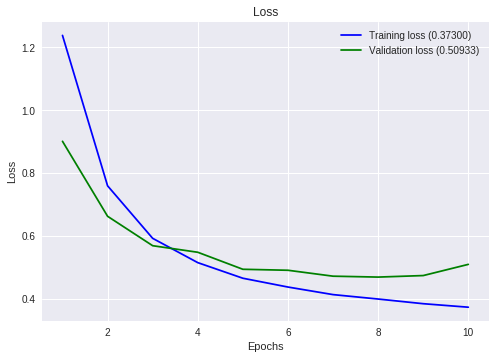

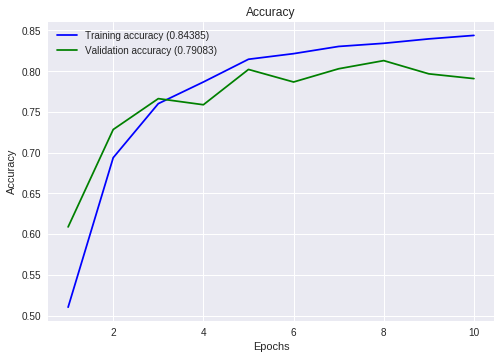

In [50]:
plot_history(history)

In [0]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

Accuracy : 0.8108333333333333

Classification Report
             precision    recall  f1-score   support

          0    0.00000   0.00000   0.00000         2
          1    0.61538   0.57143   0.59259        14
          2    0.68182   0.50000   0.57692        30
          3    0.79208   0.85106   0.82051        94
          4    0.87449   0.74483   0.80447       290
          5    0.80776   0.76265   0.78456       573
          6    0.81236   0.86891   0.83969       862
          7    0.80396   0.82207   0.81292       444
          8    0.76000   0.83516   0.79581        91

avg / total    0.81098   0.81083   0.80948      2400

[[  0   2   0   0   0   0   0   0   0]
 [  0   8   6   0   0   0   0   0   0]
 [  0   3  15  12   0   0   0   0   0]
 [  0   0   1  80  13   0   0   0   0]
 [  0   0   0   9 216  65   0   0   0]
 [  0   0   0   0  18 437 117   1   0]
 [  0   0   0   0   0  39 749  74   0]
 [  0   0   0   0   0   0  55 365  24]
 [  0   0   0   0   0   0   1  14  76]]


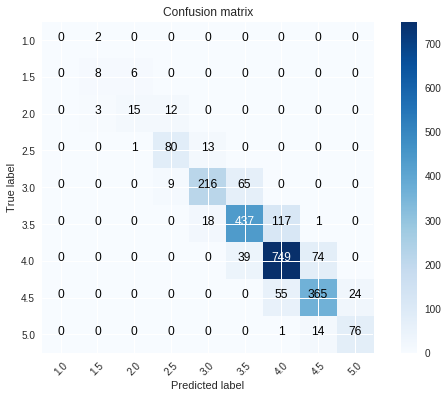

In [33]:

full_multiclass_report(model,
                       X_test,
                       y_test,
                       np.asarray([1,1.5,2,2.5,3,3.5,4,4.5,5]), batch_size = 16)

In [0]:
# pred = model.predict(X_test)
# pred.shape

In [0]:
# predict_classes = np.argmax(pred,axis=1)
 true_classes = np.argmax(y_test,axis=1)
# correct = metrics.accuracy_score(true_classes, predict_classes)
# print("Accuracy : {}%".format(correct*100))
# np.ptp(predict_classes,axis=0)


In [0]:
# print(true_classes)
# print(predict_classes)

In [0]:
activations =['relu', 'sigmoid', 'tanh']
optimizers = ['adam', 'sgd', 'rmsprop']
results ={}
for activation in activations:
  for optimizer in optimizers:
    model = Sequential()
    model.add(Dense(5, input_dim=x_data.shape[1], activation=activation)) # Hidden 1
    model.add(Dense(10, activation=activation)) # Hidden 2
    model.add(Dense(10, activation=activation)) # Hidden 3
#     model.add(Dense(10, activation=activation)) # Hidden 4
#     model.add(Dense(10, activation=activation)) # Hidden 5
    model.add(Dense(y_data_dm.shape[1], activation='softmax')) # Output

    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    monitor = EarlyStopping(monitor='val_loss', min_delta = 1e-3, patience =2, verbose=0, mode = 'auto')
    checkpoint = ModelCheckpoint(filepath=activation+'_best_model.h5', monitor='val_loss', save_best_only=True)
    
    t1 = datetime.now()
    model.fit(X_train, y_train, 
              validation_data= (X_test, y_test), 
              callbacks=[monitor, checkpoint],
              verbose=0,
              epochs=100,
              batch_size = 16
             )
    train_time = datetime.now() - t1
    
    t1 = datetime.now()
    pred = model.predict(X_test)
    predict_classes = np.argmax(pred,axis=1)
    pred_time = datetime.now() - t1

    correct = metrics.accuracy_score(true_classes, predict_classes)
    
    data = {'Accuracy (%)': correct*100, 
            'train_data': len(X_train), 
            'test_data': len(X_test), 
            'Activation': activation, 
            'Optimizer': optimizer,
            'Train Time (sec)' : (train_time.total_seconds()),
            'Prediction Time (sec)': (pred_time.total_seconds()) 
            
           }
    results[activation+"_"+optimizer] =  data
results_project_2 = pd.DataFrame(results)

In [39]:
print("Results of different types of Neural Network Models")
results_project_2
# print("Results of different types of Classification Models from project 1")
# print(results_project_1)

Results of different types of Neural Network Models


,relu_adam,relu_rmsprop,relu_sgd,sigmoid_adam,sigmoid_rmsprop,sigmoid_sgd,tanh_adam,tanh_rmsprop,tanh_sgd
Accuracy (%),80.625,79.5833,76.3333,79.8333,77.8333,35.9167,78.625,80.25,75.2917
Activation,relu,relu,relu,sigmoid,sigmoid,sigmoid,tanh,tanh,tanh
Optimizer,adam,rmsprop,sgd,adam,rmsprop,sgd,adam,rmsprop,sgd
Prediction Time (sec),0.099076,0.120454,0.108447,0.156814,0.174421,0.151198,0.199086,0.217598,0.219569
Train Time (sec),12.8109,8.05545,12.0193,21.0969,19.7594,10.6709,13.8235,12.683,15.0194
test_data,2400,2400,2400,2400,2400,2400,2400,2400,2400
train_data,9600,9600,9600,9600,9600,9600,9600,9600,9600


In [40]:
print("Results of different types of Classification Models from project 1")
results_project_1

Results of different types of Classification Models from project 1


,KNN,Logistic Regression,Multinomial NB,SVM Linear,SVM Poly,SVM RBF,SVM Sigmoid
Accuracy,47.04 %,63.42 %,44.21 %,77.0 %,35.92 %,54.67 %,44.79 %
Prediction time (sec),43.159,0.009355,0.012888,21.7149,39.7847,41.4477,41.079
Test Data Size,2400,2400,2400,2400,2400,2400,2400
Train Data Size,9600,9600,9600,9600,9600,9600,9600
Training time (sec),0.951741,64.6023,0.066121,77.1009,212.13,190.48,205.853


In [0]:
X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size = test_data_size, random_state=42)

In [0]:
model = Sequential()
model.add(Dense(50, input_dim=x_data.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta = 1e-3, patience =2, verbose=0, mode = 'auto')
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

t1 = datetime.now()
model.fit(X_train, y_train, 
          #validation_data= (X_test, y_test), 
          callbacks=[monitor, checkpoint],verbose=0,epochs=100)
train_time = datetime.now() - t1

In [43]:
pred = model.predict(X_test)
print("Shape: {}".format(pred.shape))
# print(pred[0:5])
# print(y_test[0:5])

Shape: (2400, 1)


In [44]:
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
regression_results['NN Regression'] = {'RMSE': score, 'Training Time': train_time.total_seconds()}

Final score (RMSE): 0.24329959693514341


In [45]:
pd.DataFrame(regression_results)

,Linear Regression,NN Regression
RMSE,0.211804,0.243300
Training Time,3.446175,54.101838
